In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from utils.dcm_utils import *
from utils.nii_utils import *

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# DATA_DIR = "/Volumes/SSD970/"
DATA_DIR = "/media/longyi/SSD9701/"
TRAIN_SEG_DIR = os.path.join(DATA_DIR, "segmentations")
TRAIN_IMAGE_DIR = os.path.join(DATA_DIR, "train_images")

## Dataset

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, seg_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.seg_dir = seg_dir

        self.nii_files = glob.glob(seg_dir + "/*.nii")

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.nii_files)

    def __getitem__(self, idx):

        nii_path = self.nii_files[idx]
        UID = nii_path.split("/")[-1].replace(".nii", "")


        imgs, image_positions, image_orientations, pixel_spacings, slice_thicknesses, is_flip = read_patient_dcm(UID, self.image_dir)
        height = image_positions[0, 2] - image_positions[1, 2]
        pixel_spacing = pixel_spacings[0, 0]
        aspect = np.round(height / pixel_spacing)
        img3d = np.repeat(imgs, aspect, axis=0)

        # get segmentation
        seg = read_patient_nii_mask(UID, self.seg_dir)
        if is_flip is False:
            seg = np.flip(seg, axis=0)
        seg3d = np.repeat(seg, aspect, axis=0)

        if self.transform:
            img3d = self.transform(img3d)
        if self.target_transform:
            seg3d = self.target_transform(seg3d)
        return img3d, seg3d
dataset = SegmentationDataset(TRAIN_IMAGE_DIR, TRAIN_SEG_DIR)
image, label = dataset[0]
print(image.shape)
print(label.shape)

(858, 512, 512)
(858, 512, 512)


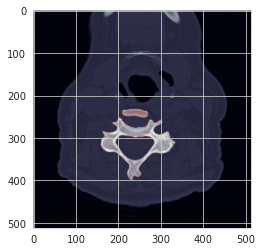

In [5]:
slice = 500
plt.imshow(image[slice, :, :], cmap='bone')
plt.imshow(label[slice, :, :], alpha=0.4)
plt.show()

## Transform

In [6]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, pin_memory=True)

In [7]:
x, y = next(iter(dataloader))
x = x.to(device)
y = y.to(device)

In [8]:
x.shape

torch.Size([1, 651, 512, 512])

In [9]:
y.shape

torch.Size([1, 651, 512, 512])

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()

        self.layer = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv3d(in_channels, hidden_channels, 1, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(hidden_channels, hidden_channels, 3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Conv3d(hidden_channels, in_channels, 1, padding='same')
        )

    def forward(self, x):
        out = self.layer(x)
        out += x
        return out

In [11]:
class SegmentationModel(nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.layer = nn.Sequential(
            nn.Conv3d(1, hidden_channels, 7, padding='same'),
            ResidualBlock(hidden_channels, hidden_channels),
            ResidualBlock(hidden_channels, hidden_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(hidden_channels, 1, 1, padding='same')
        )

    def forward(self, x):
        out = self.layer(x)
        return out


In [12]:
model = SegmentationModel(32).to(device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

pytorch_total_params

70625

In [13]:

x = x.unsqueeze(1)
pred = model(x)
pred.shape

RuntimeError: CUDA out of memory. Tried to allocate 40.69 GiB (GPU 0; 11.77 GiB total capacity; 2.54 GiB already allocated; 7.83 GiB free; 2.54 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF